In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pyabc

import healpy as hp
from scipy.special import sph_harm
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import multipoles
import generate_mocks as gm

In [3]:
plt.rcParams["font.family"] = "serif"

## quasar catalogs

In [4]:
blim = 30
nside_hi = 64
resdir = '/scratch/aew492/lss-dipoles_results/results'

In [44]:
# expected dipole direction
cmb_dipdir = dipole.cmb_dipole()[1]

#### Quaia

In [39]:
# selfunc
selfunc_quaia = gm.get_selfunc_map('quaia_G20.0_orig', nside=nside_hi, blim=blim)

# load data
# masked
quaia_qmap = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked.npy'))
# the above map smoothed to 1sr
quaia_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_smoothed_1sr.npy'))
# correct by selfunc
quaia_qmap_corr = quaia_qmap / selfunc_quaia
# load the selfunc-corrected, smoothed map
quaia_qmap_corr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_corr_smoothed_1sr.npy'))

# base rate for mocks
base_rate_quaia = 33.6330

In [40]:
# hp.fit_dipole result
hp_dipole_quaia = hp.fit_dipole(quaia_qmap_corr)[1] / hp.fit_dipole(quaia_qmap_corr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_quaia)
dipamp, dipdir.galactic

(0.016920084644413365,
 <SkyCoord (Galactic): (l, b) in deg
     (322.42198035, 25.75735906)>)

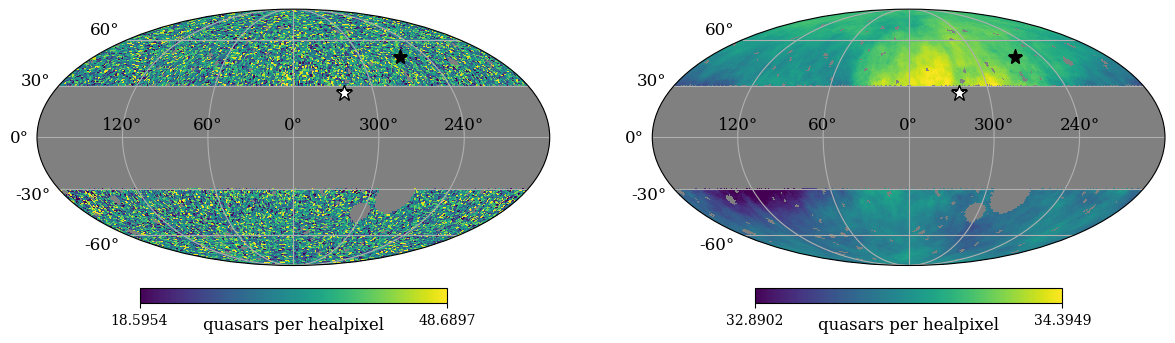

In [48]:
# plot
fig = plt.figure(figsize=(12,5))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(quaia_qmap_corr), np.nanstd(quaia_qmap_corr)
hp.projview(quaia_qmap_corr, min=mean-2*std, max=mean+2*std, title='', sub=(1,2,1), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
hp.projview(quaia_qmap_corr_smoothed, min=mean-0.1*std, max=mean+0.1*std, title='', sub=(1,2,2), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)

#### CatWISE

In [37]:
# selfunc
selfunc_catwise = gm.get_selfunc_map('catwise_elatcorr', nside=nside_hi, blim=blim)

# load data
# masked
catwise_qmap = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked.npy'))
# the above map smoothed to 1sr
catwise_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_smoothed_1sr.npy'))
# selfunc-corrected
catwise_qmap_corr = catwise_qmap / selfunc_catwise
# selfunc-corrected and smoothed
# catwise_qmap_corr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_corr_smoothed_1sr.npy'))
catwise_qmap_corr_smoothed = tools.smooth_map(catwise_qmap_corr, sr=1)

# base rate for mocks
base_rate_catwise = 77.4495

In [49]:
# hp.fit_dipole result
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr)[1] / hp.fit_dipole(catwise_qmap_corr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dipamp, dipdir.galactic

(0.015334348323861371,
 <SkyCoord (Galactic): (l, b) in deg
     (237.73551446, 28.88093137)>)

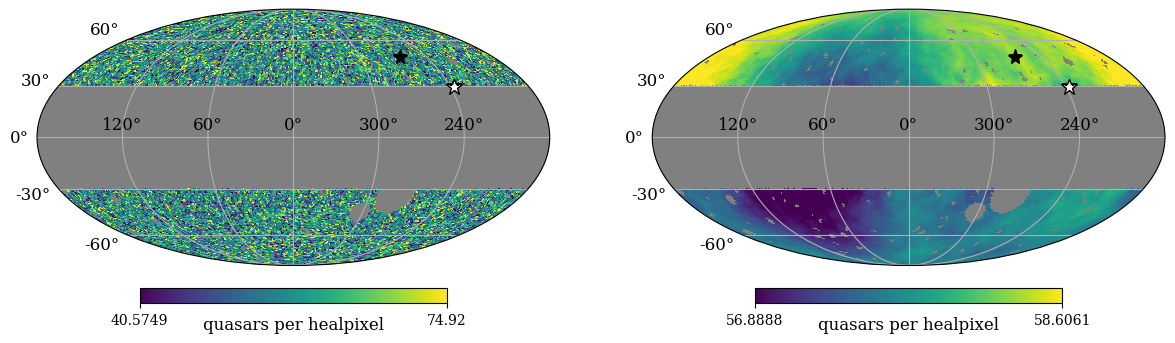

In [50]:
# plot
fig = plt.figure(figsize=(12,5))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(catwise_qmap_corr), np.nanstd(catwise_qmap_corr)
hp.projview(catwise_qmap_corr, min=mean-2*std, max=mean+2*std, title='', sub=(1,2,1), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)
hp.projview(catwise_qmap_corr_smoothed, min=mean-0.1*std, max=mean+0.1*std, title='', sub=(1,2,2), **kwargs)
tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='k', mec='k', ms=11)

#### selection functions

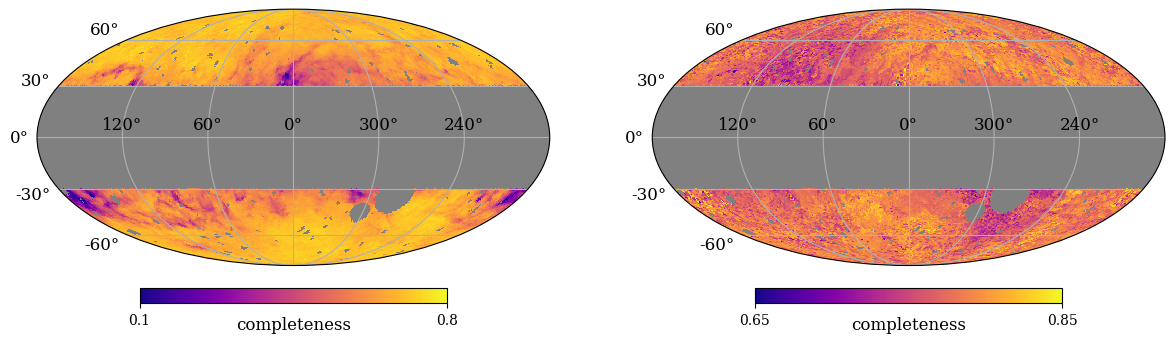

In [55]:
# plot
fig = plt.figure(figsize=(12,5))
kwargs = dict(coord=['C','G'], cmap='plasma', unit='completeness', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
selfunc_quaia_ = np.copy(selfunc_quaia)
selfunc_quaia_[selfunc_quaia <= 0.] = np.nan
selfunc_catwise_ = gm.get_selfunc_map('catwise_zodi', nside=nside_hi, blim=blim) # np.copy(selfunc_catwise)
selfunc_catwise_[selfunc_catwise <= 0.] = np.nan
hp.projview(selfunc_quaia_, title='', min=0.1, max=0.8, sub=(1,2,1), **kwargs)
hp.projview(selfunc_catwise_, title='', min=0.65, max=0.85, sub=(1,2,2), **kwargs)